In [ ]:
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d


# Initial definitions of constants and inputs

In [2]:
def TimeDiffInDays(date1, date2):
    timediff_seconds = (date2-date1).total_seconds()
    return timediff_seconds / 60. / 60. / 24.


In [20]:
# Define the constants
Bq_per_uCi = 37000.
N_A = 6.02e23
m_Xe = 131. # g/mol
Pa_per_psi = 6894.757
mL_per_m3 = 1e6
T_half = 36.346 # days
T_life = T_half / np.log(2)


# Volumes
cylinder_vol = 150 # mL
expansion_vol = 5.6 # mL


# Initial pressure
init_pressure = 850 # psia


# Initial activity 
irradiation_date = dt.datetime(2022, 4, 8, 12, 30, 5)
measurement_date = dt.datetime(2022, 5, 13, 16, 45, 20)
measured_activity = 3.6442E-01 # uCi
init_activity = measured_activity / np.exp(-TimeDiffInDays(irradiation_date, measurement_date) / T_life)


# Density vs pressure data, from NIST webbook. Units of g/mL vs psia.
density_vs_pressure_data = np.genfromtxt('xenon_density_vs_pressure_at_295K.txt', skip_header=1)[:,1:3]
density_vs_pressure = interp1d(density_vs_pressure_data[:,0], density_vs_pressure_data[:,1])




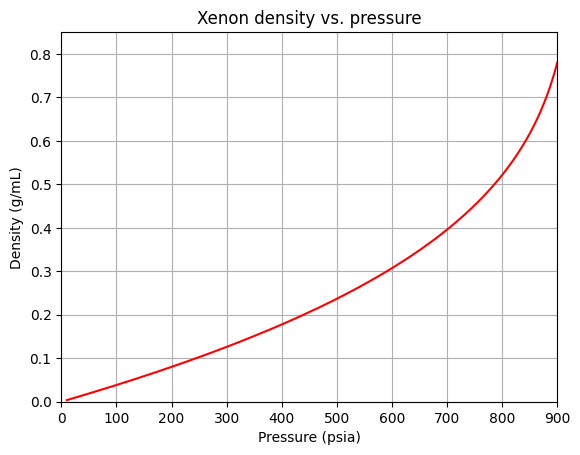

In [19]:
plt.plot(density_vs_pressure_data[:,0], density_vs_pressure_data[:,1], '-r')
plt.xlabel('Pressure (psia)')
plt.ylabel('Density (g/mL)')
plt.xlim(0.,900.)
plt.ylim(0.,0.85)
plt.grid()
plt.title('Xenon density vs. pressure')

plt.show()



## Define functions

In [21]:
def GetCurrentActivityPerGram( current_date ):
    delta_t = TimeDiffInDays( irradiation_date, current_date )
    init_mass = density_vs_pressure( init_pressure ) * cylinder_vol
    current_activity_per_g = init_activity/init_mass * np.exp(-delta_t / T_life)

    return current_activity_per_g



def GetCurrentActivtyPerPuff( current_date, current_pressure_psi ):
    current_activity_per_g = GetCurrentActivityPerGram( current_date )
    current_density_in_cyl = density_vs_pressure( current_pressure_psi )
    
    current_activity_in_cyl = current_activity_per_g * current_density_in_cyl * cylinder_vol
    
    activity_per_puff = current_activity_in_cyl * expansion_vol / (cylinder_vol + expansion_vol)
    
    return activity_per_puff


    

## Plot activities vs time, assuming you still have 850 psi in cylinder

In [31]:
current_pressure = 850 # psia

days_elapsed = np.linspace(0.,215, 500)
xvals = []
yvals_per_g = []
yvals_per_puff = []

for x in days_elapsed:
    t_elapsed = dt.timedelta(days=x)
    
    xdate = irradiation_date + t_elapsed
    
    xvals.append( xdate )
    
    yvals_per_g.append( GetCurrentActivityPerGram(xdate) )
    
    yvals_per_puff.append( GetCurrentActivtyPerPuff( xdate, current_pressure ) )
       
xvals = np.array(xvals)
yvals_per_g = np.array(yvals_per_g)
yvals_per_puff = np.array(yvals_per_puff)


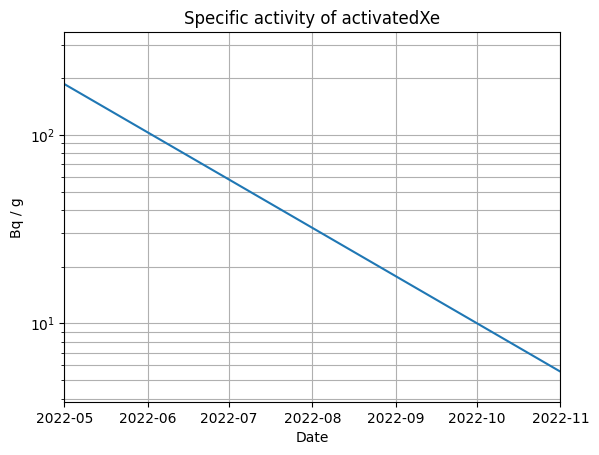

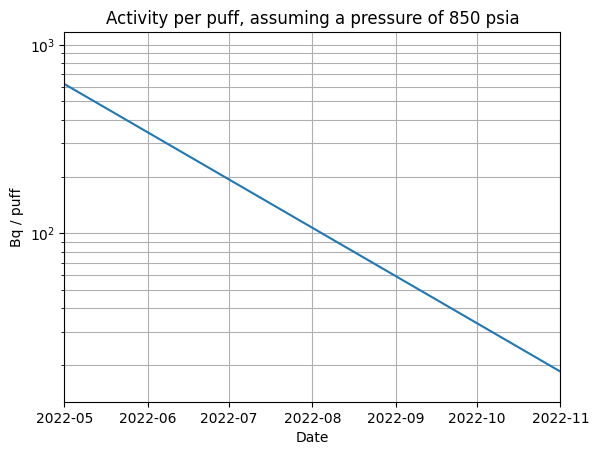

In [40]:
plt.figure(1)
plt.plot(xvals, yvals_per_g * Bq_per_uCi)
plt.yscale('log')
plt.grid(which='both')
plt.title('Specific activity of activatedXe')
plt.xlabel('Date')
plt.ylabel('Bq / g')
plt.xlim(dt.datetime(2022,5,1), dt.datetime(2022,11,1))

plt.figure(2)
plt.plot(xvals, yvals_per_puff * Bq_per_uCi)
plt.yscale('log')
plt.grid(which='both')
plt.title('Activity per puff, assuming a pressure of {} psia'.format(current_pressure))
plt.xlabel('Date')
plt.ylabel('Bq / puff')
plt.xlim(dt.datetime(2022,5,1), dt.datetime(2022,11,1))

plt.show()

## Get the numbers for the current date

In [45]:
current_date = dt.datetime( 2022, 10, 12 )
current_pressure = 850 # psia

current_activity_in_cyl = GetCurrentActivityPerGram( current_date ) * \
                            density_vs_pressure(current_pressure) * \
                            cylinder_vol * Bq_per_uCi

print('Current activity in the cylinder is: {:4.4} Bq'.format(\
                            current_activity_in_cyl ) )
print('Current activity injected per puff is: {:4.4} Bq'.format(\
                            GetCurrentActivtyPerPuff( current_date, current_pressure) * Bq_per_uCi ) )

Current activity in the cylinder is: 752.8 Bq
Current activity injected per puff is: 27.09 Bq
